In [299]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Union
from collections import Counter
from tqdm.notebook import tqdm
from spacy.language import Language
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from ipywidgets import Dropdown, interactive
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 30)


# Sourcing Data

In [4]:
# Changing path for local file read
PATH = 'BookingDotCom_HotelReviews.xlsx'
# Reading Data
df = pd.read_excel(PATH)

# Questions

## 1. What are the top hotel features that guests talk about the most in their Booking.com reviews? Since this is a copy-and-paste from class handout, no points are assigned for this question. (0 point)


In [291]:
# Fetching Spacy English Library
nlp = spacy.load('en_core_web_sm')

# Removing if stopper already in pipelin
if 'custom_sentence_stop' in nlp.pipe_names:
    nlp.remove_pipe('custom_sentence_stop')

# Pipeline cleaning function
@Language.component('custom_sentence_stop')
def add_custom_sentence_stop(doc):
    """Adds a sentence beginnings where capitalized words begin as long as they are not pronouns
        - doc(spacy.Doc): text
    
    Returns: Doc string with sentence delimiters
    """
    for token in doc[:-1]:
        if token.is_title and (token.text != 'I' and token.pos_ !='PRON'):
            doc[token.i].is_sent_start = True
            # print(token, 'is new sent start')
    return doc

# Adding custom cleaning component to Spacy pipeline that will allow us to split by sentences since we have no punctuations
nlp.add_pipe('custom_sentence_stop', before='parser')
# Checking new step is added
nlp.pipe_names

['tok2vec',
 'tagger',
 'custom_sentence_stop',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [298]:
# Sourced from ISM6930 class, returns top nouns
def top_features(df=pd.DataFrame) -> Counter:
    """Returns ordered number of nouns found in the text"""
    lemmatizer = WordNetLemmatizer()
    df = df.astype(str)
    comment_list = df.tolist()                                     # Convert a Pandas series to a list
    comment_list = [c for c in comment_list if pd.isnull(c)==False]
    comment_str  = ' '.join(comment_list)                          # Concatenate all comments to one string
    words = nltk.word_tokenize(comment_str) 
    words = [w for w in words if len(w)>2]
    words = [lemmatizer.lemmatize(w) for w in words]
    tagged = nltk.pos_tag(words, tagset='universal')               # Extract POS tags for each word                               
    noun = [w[0] for w in tagged if w[1]=='NOUN']
    return nltk.FreqDist(noun)                                     # Return freq distribution counter of NOUN strings

In [36]:
# Creating series of Reviews for each type. Not inclusive of empty. Also lowercaps
dpos = df['Positive_Review'][df['Positive_Review']!="No Positive"].str.lower()
dneg = df['Negative_Review'][df['Negative_Review']!="No Negative"].str.lower()

# Fetching top features from each comment list
pos_features = top_features(dpos)
neg_features = top_features(dneg)

# Showing most common 20 for selection
print('Most Common Positive:')
print(pos_features.most_common(20))
print('Most Common Negative:')
print(neg_features.most_common(20))

Most Common Positive:
[('staff', 196634), ('location', 191641), ('room', 181116), ('wa', 133273), ('hotel', 128633), ('breakfast', 80076), ('bed', 46446), ('station', 32140), ('service', 27260), ('everything', 27137), ('restaurant', 22642), ('bar', 22327), ('view', 21522), ('area', 18746), ('bathroom', 18371), ('facility', 17216), ('stay', 17207), ('food', 16764), ('reception', 15571), ('city', 15399)]
Most Common Negative:
[('room', 210828), ('wa', 123215), ('hotel', 79411), ('breakfast', 54091), ('staff', 39979), ('nothing', 38789), ('night', 28380), ('bed', 28059), ('bathroom', 27454), ('time', 23604), ('day', 20785), ('service', 20382), ('bit', 20140), ('bar', 19483), ('price', 18069), ('didn', 16925), ('floor', 16542), ('reception', 16428), ('door', 14536), ('water', 14318)]


In [297]:
"""
The top selected features per each class
"""

def filter_top_features(positive:Counter, negative:Counter, excluded_words:list, top_num:int=5) -> dict:
    """Returns top number of selected features for each class
        - positive(Counter): top positive words 
        - negative(Counter): top negative words 
        - excluded_words(List): list to exclude
        - top_bum: number of features to keep
    """
    final_selected = dict()
    features = {'positive':positive, 'negative':negative}
    for name, feature in features.items() :
        selected = list()
        # getting top words in order
        num = 0
        for key, value in feature.most_common(10):
            if num == top_num: break
            # passing if in excluded list
            if key in excluded_words:
                continue
            # adding word to list
            selected.append(key)
            num += 1
        final_selected.update({name:selected})
    return final_selected

# excluding words that don't make sense
excluded = ['wa', 'nothing', 'night']
# selecting top features per class
selected_features = filter_top_features(pos_features, neg_features, excluded)

selected_features

{'positive': ['staff', 'location', 'room', 'hotel', 'breakfast'],
 'negative': ['room', 'hotel', 'breakfast', 'staff', 'bed']}

After appropriate cleaning and selection of nouns, we end with the top features for each review type (positve/negative). Most features seem to align except with location (positive), bed (negative). If we are to consolidate these we would end up with top 6 words:

1. staff
2. room 
3. hotel 
4. breakfast
5. location 
6. bed

## 2. Score each guest review along each of the above features. Note that features that are not mentioned in a given review should receive no score for that review. You may use the approach discussed in class or a different approach of your choice. (4 points)

In [12]:
"""Cleaning function"""

def clean_reviews(df):
    """Ensures all comments are string types and removes Empty review tags to empty strings."""
    # Replacing with Empty string
    df.loc[df['Positive_Review'] == "No Positive", 'Positive_Review'] = ""
    df.loc[df['Negative_Review'] == "No Negative", 'Negative_Review'] = ""
    # Ensuring all are str type
    df['Positive_Review'] = df['Positive_Review'].astype(str)
    df['Negative_Review'] = df['Negative_Review'].astype(str)
    return df
    
df = clean_reviews(df)


In [23]:
"""
Creating steps to extract sentences with top features per each review comment and score sentiment related to that feature in the sentence.
"""

def extract_sentence(review:str,top_features:list) -> dict:
    """
    Given a review and a list of top features returns a dictonary of each sentence that mentions such feature
    - review: string of review
    - top_features: list of top features
    """
    feature_sents = dict()
    # compiles features into regex for matching
    features = ".|".join(top_features)
    re_compiled = re.compile(features)
    # if review mentions feature extract sentences
    if re.search(re_compiled, review.lower()):
        doc = nlp(review)
        for feature in top_features:
            sents = list()
            for sent in doc.sents:
                if feature in sent.text.lower():
                    # append sentence
                    sents.append(sent.text)
            # add feature and sentence pairs
            feature_sents.update({feature:sents})
    return feature_sents


def get_sentiment(feature_sents:dict) -> Union[float, np.nan]:
    """Given a sentence(s) scores sentiment per each and averages if mentioned mulitple times. If not mentioned returns null
        - feature_sents(dict): dictionary of feature and sen sentence
    """
    analyzer = SentimentIntensityAnalyzer()
    feature_score = dict()
    for feature, sent_list in feature_sents.items():
        score = list()
        # add if sent_list greater than 1 average
        for sent in sent_list:
            compound_value = analyzer.polarity_scores(sent)['compound']
            # print(sent, compound_value)
            score.append(compound_value)
        if len(score) > 1:
            score = np.mean(score)
        elif len(score) == 0:
            score = np.nan
        else:
            score = score.pop()
        feature_score.update({feature:score})
    return feature_score

def score_features(df:pd.DataFrame, selected_features:dict) -> pd.DataFrame:
    """Master function to score all reviews. Returns a dataframe with scores for each top feature prefixed by their review type(positive/negative). 
    
    Progress used for time measurement of task for big data analysis
        - df: dataframe with reviews
        - selected features for analysis
    
    Returns: dataframe with scores
    """
    pbar = tqdm(total = int(df.shape[0]) *2)
    for key, top_features in selected_features.items():
        feat_type = key
        prefix_ = feat_type[:3]
        column_name = feat_type.capitalize() + "_Review"
        ## assign scores per feature set
        for index, row in df.iterrows():
            review = row[column_name]
            feature_sents = extract_sentence(review, top_features)
            feature_scores = get_sentiment(feature_sents)
            for key, value in feature_scores.items():
                df.loc[index, prefix_ +'_'+ key] = value
            pbar.update(1)
    pbar.close()
    return df

In [24]:
""" 
Scoring all features. 

NOTE: this task took 5.5 hours to complete. Pickled file included for analysis in cell below
"""

df = score_features(df, selected_features)
df.head()

  0%|          | 0/1031476 [00:00<?, ?it/s]

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Reviewer_Nationality,Positive_Review,Negative_Review,Total_Reviewer_Reviews,...,neg_room,neg_hotel,neg_breakfast,neg_staff,neg_bed,pos_staff,pos_location,pos_room,pos_hotel,pos_breakfast
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Russia,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7,...,-0.053022,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.5994,NaN
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,No real complaints the hotel was great great ...,,7,...,NaN,NaN,NaN,NaN,NaN,0.0276,0.6486,0.6486,0.6486,NaN
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,9,...,-0.393950,NaN,NaN,NaN,NaN,0.6249,0.6249,NaN,0.7003,0.7003
3,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,United Kingdom,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,1,...,-0.012800,-0.3174,NaN,0.4019,0.3533,NaN,0.9260,NaN,NaN,NaN
4,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-24,New Zealand,Amazing location and building Romantic setting,You When I booked with your company on line y...,3,...,-0.159100,NaN,NaN,0.0000,NaN,NaN,0.5859,NaN,NaN,NaN


In [300]:
"""Saving and reading from pickled file for speed and reproduction"""

# df.to_pickle('hotel_reviews.pkl')
df = pd.read_pickle('hotel_reviews.pkl')

In [301]:
"""Combines features for both positive and negative comments into top 6 reviews"""

# Selecting feature columns for negative and positive comments
score_cols = [col for col in df if col.startswith('neg') or col.startswith('pos')]

# creating averaging features per review
for score in score_cols:
    pair = [score_pair for score_pair in score_cols if score_pair[4:] == score[4:]]
    df[score[4:]] = df[pair].mean(axis=1)

In [302]:
# selecting only certaing columns (eliminating separated negative/positive scores)
columns = ['Hotel_Name', 'Hotel_Address', 'Review_Count',
       'Non_Review_Scoring_Count', 'Average_Hotel_Score', 'Review_Date',
       'Reviewer_Nationality', 'Positive_Review', 'Negative_Review',
       'Total_Reviewer_Reviews', 'Reviewer_Score', 'Tags', 'room',
       'hotel', 'breakfast', 'staff', 'bed', 'location',]
       
df = df[columns]

## 3. Compute the average feature score for each review, and report the correlation between this average score and the “Reviewer_Score” column in the data file. A strong positive correlation (>0.70) would indicate that your scoring mechanism worked. If your correlation was not up to the mark, you may want to explore what you can do to improve it.(1 point)

In [307]:
# Creating average feature score
cols = ['room','hotel','breakfast','staff','bed', 'location']
df['avg_feature_score'] = df[cols].mean(axis=1)

In [310]:
"""Checking correlation"""
df[['avg_feature_score', 'Reviewer_Score']].corr()

,avg_feature_score,Reviewer_Score
avg_feature_score,1.000000,0.505598
Reviewer_Score,0.505598,1.000000


Correlation appears to be maximumn of 50.6%, will try to use scaling before creating the average to see if we can improve correlations

In [311]:
# Getting current min/max ranges of reviews
min_review = df['Reviewer_Score'].min()
max_review = df['Reviewer_Score'].max()

# Scaling each feature individually before creating average score
for col in df[cols].columns:
    df[col] = minmax_scale(df[col],(min_review, max_review))

# Score scaled. Using scaling before average
df['avg_feature_scaled'] = df[cols].mean(axis=1)

In [313]:
# Getting correlation of scaled value
df[['avg_feature_scaled', 'Reviewer_Score']].corr()

,avg_feature_scaled,Reviewer_Score
avg_feature_scaled,1.000000,0.503543
Reviewer_Score,0.503543,1.000000


Using new feature with individual features scaled before averaging does not seem to improve correlation. It instead decreased to 50.3%

In [316]:
# scaling avg feature for plotting in question 5
df['avg_feature_score'] = minmax_scale(df['avg_feature_score'],(min_review, max_review))

## 4. Compute average feature-wise score for each hotel (across all reviews) and report the correlation between these computed hotel scores and Average_Hotel_Score. (1 point).

In [318]:
"""
Creating feature-wise average per each hotel. Grouping by address and name due to duplicate names
"""

# Creating average feature-wise values
for score in cols:
    df['avg_'+ score] = df.groupby(['Hotel_Name', 'Hotel_Address'])[score].transform('mean')

# Creating average of all features for feature-wise
df['avg_hotel_feature'] = df.groupby(['Hotel_Name', 'Hotel_Address'])['avg_feature_score'].transform('mean')

# Getting Correlation with Avg. Hotel Rating
df[['avg_' + score for score in cols] + ['Average_Hotel_Score']].corr().iloc[-1,:].sort_values(ascending=False)

Average_Hotel_Score    1.000000
avg_hotel              0.819613
avg_room               0.793821
avg_staff              0.639965
avg_location           0.541598
avg_bed                0.290761
avg_breakfast          0.279221
Name: Average_Hotel_Score, dtype: float64

It appears that when we look at the correlations feature-wise Hotel and Room feature scores have a correlation above 70%, showing that these appear to be valuable features. Staff follows at 63%. Bed and breakfast appears to have the lowest correlations

## 5. Create a dashboard with the following plots: (1) Ten highest rated hotels in Europe (showing your aggregate score and Average_Hotel_Score), (2) Ten highest rated hotels for each of the top five features identified in Question 1. (2 points).



In [319]:
# Checking number of unique hotel rows
size = df[['Hotel_Name', 'Hotel_Address']].drop_duplicates().shape[0]
print(f'Unique hotel rows before drop: {size}')

# Selecting columns and dropping rest
columns = ['Hotel_Name', 'Hotel_Address', 'Review_Count',
       'Non_Review_Scoring_Count', 'Average_Hotel_Score', 'avg_hotel_feature',
       'avg_room', 'avg_hotel', 'avg_breakfast', 'avg_staff', 'avg_bed',
       'avg_location']
hotels = df[columns].drop_duplicates()

# After drop size check
print(f'Unique hotel rows before drop: {hotels.shape[0]}')


Unique hotel rows before drop: 1494
Unique hotel rows before drop: 1494


In [324]:
# Sorting the values by avg_hotel_score and average features
hotels = hotels.sort_values(['Average_Hotel_Score', 'avg_hotel_feature'], ascending=False)

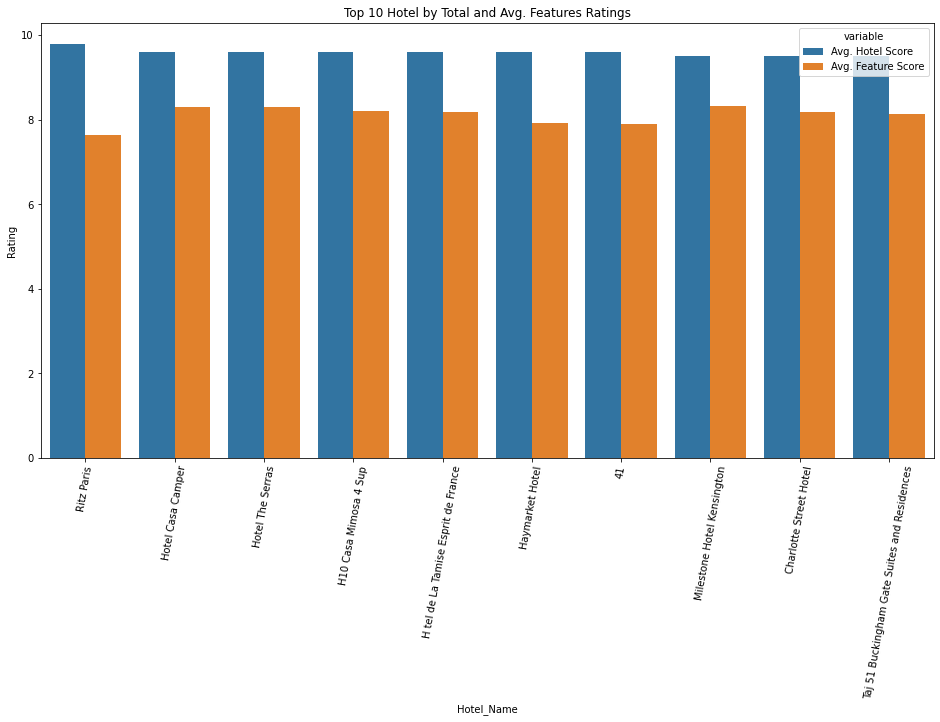

In [326]:
"""The top 10 hotels, with the exception of the Ritz, appear to have high feature scores of around 8 points, showing some parity between features and scores"""

# Selecting top 10 hotels with calculated score and score from review
top_hotels_agg = pd.melt(hotels[['Hotel_Name','Average_Hotel_Score', 'avg_hotel_feature']]
    .iloc[:10]
    .rename(
        columns={
            'avg_hotel_feature':'Avg. Feature Score', 
            'Average_Hotel_Score':'Avg. Hotel Score'}), 
        id_vars=['Hotel_Name'])

# Plotting top 10 hotels
plt.figure(figsize=(16,8), num=None)
sns.barplot(y='value',
             x='Hotel_Name',
             hue='variable',
             data=top_hotels_agg)
plt.xticks(rotation=80)
plt.title('Top 10 Hotel by Total and Avg. Features Ratings')
plt.ylabel('Rating')
plt.show()

In [331]:
# Saving to read from Github
# hotels.to_csv('aggregated_hotels.csv', index=False)

In [332]:
"""Creating plot of top 10 hotels by feature"""

# Read data from github to reproduce interactive dashboard
hotels = pd.read_csv("https://raw.githubusercontent.com/jvac06/nlp_assignments/main/aggregated_hotels.csv")

# Creating Dropdown menu with features
feature_dropdown = Dropdown(
    options= [(feature.capitalize(),'avg_'+ feature) for feature in ['room', 'hotel', 'breakfast', 'staff', 'bed', 'location']],
    value='avg_room',
    description='Feature:')

def update_plot(feature:str) -> None:
    """Feeds selected feature from drop down and returns sorted top 10 hotels by this feature
        - feature: selected feature from drop down
    """
    plt.figure(figsize=(20,8), num=None)
    sns.barplot(x='Hotel_Name',
    y=feature,
    # Top 10 Sorted data by feature
    data=hotels.sort_values(feature,ascending=False).iloc[:10])
    plt.xticks(rotation=60)
    name = feature.split("_")[1].capitalize() + ' Feature'
    plt.title(f'Top 10 Hotel by {name}')
    plt.ylabel(name)

# Shows interactive plot to select feature and plot top 10 hotels
interactive(update_plot, feature=feature_dropdown)

interactive(children=(Dropdown(description='Feature:', options=(('Room', 'avg_room'), ('Hotel', 'avg_hotel'), …

The top 10 hotels, with the exception of the Ritz, appear to have high feature scores as well as Avg_Hotel_Scores.

For the top 10 hotel by features differ can be seen in the dashboard provided. You must select the feature and the top 10 will be shown. The top one is listed for convinience as well:

    - Room: Hotel Eiffel Blomet

    - Hotel: Pershing Hall

    - Staff: Le Saint Gregoire

    - Location: Hotel Eitlk rg
    
    - Bed: Hotel Dupond Smith

## 6. Regress Average_Hotel_Score against the top five feature scores of each hotel, and provide quantitative estimates of how important each feature is for the Average_Hotel_Score. (2 points)

In [279]:
"""Preparing data for linear regression"""

# Removing nulls
data = hotels.dropna()

# Selecting X values
features = ['room', 'hotel', 'breakfast', 'staff', 'bed', 'location']

# preparing signal and response variables
X = data[['avg_'+ feature for feature in features]]
y = data['Average_Hotel_Score']

In [287]:
"""Fitting and Reading coefficients."""

# Instantiating Linear Regression
linear_reg = LinearRegression()
# Fitting
linear_reg.fit(X, y)
# Getting coefficients with names
coefficients = dict(zip(features,linear_reg.coef_))
coefficients = {k:round(v,3) for k,v in sorted(coefficients.items(), key=lambda item: item[1],reverse=True)}
# Top Coeffients by order
coefficients

{'hotel': 0.551,
 'room': 0.547,
 'staff': 0.189,
 'location': 0.025,
 'bed': 0.023,
 'breakfast': 0.014}

The top feature scores can be given a quantitative value to the Average Hotel Scores by getting to coefficients of each of these features. Doing this we see that the top 3 features are 1) hotel 2) room and 3) staff.

for every point increase in the:

- hotel feature, average hotel scores increase by .551 points
- room feature, average hotel scores increase by .547 points
- staff feature, averge hotel scores increase by .189 points